In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from utils import parse_stats, get_stat_dfs, trim_column_names, REAL_POLICIES, REAL_LABELS, MODEL_LABELS, merge
import matplotlib
matplotlib.rcParams.update({'font.size': 12})

In [2]:
real_path = Path("../../results/faro/resnet34/2_top9_twitter_1_1600_avgproc_min_int5m_reduced_6hr_augmented/latency_stats.pkl")
real_df = parse_stats(real_path)

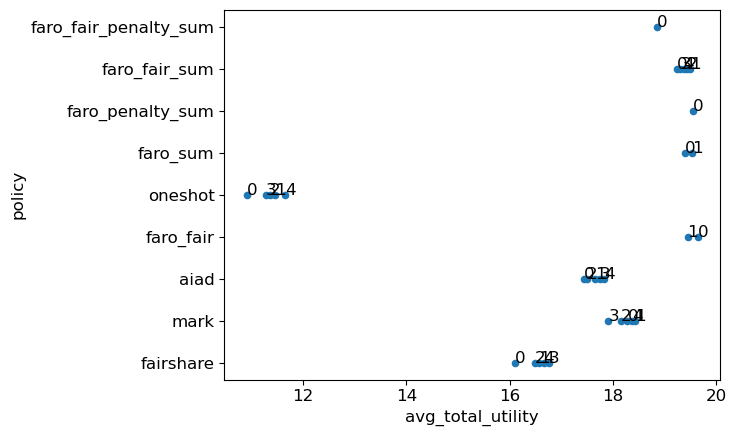

In [3]:
# visualize values for each policy

df = real_df[real_df.num_cpus == "70"]
policies = REAL_POLICIES
labels = REAL_LABELS
model_labels = MODEL_LABELS
target_df = df[
    # & (df.latency_estimator != "max_latency")
    (df.latency_estimator != "p80_latency")
    # & (df.pred_aggr != "pred_max") & (df.pred_aggr != "pred_p80")
    & (df.pred_aggr != "pred_p80") & (df.pred_aggr != "pred_avg") #& (df.pred_aggr != "pred_max")
    # & (df.pred_aggr != "pred_p80") & (df.pred_aggr != "pred_avg") & (df.pred_aggr != "pred_none")
    & (df.model_config != "model_4") & (df.model_config != "model_5") & (df.model_config != "model_6") # & (df.model_config != "model_8")
    & (df.model_config != "model_10")
    & (df.ws != "300s") & (df.ws != "480s")
    & (df.idle_timeout != "5s")
    & (~df.policy.str.endswith("utility_latency"))
    & (~df.policy.str.contains("scale"))
    & (~df.policy.str.contains("w_current"))
    & (~df.policy.str.contains("sqrt"))
    & (~df.policy.str.contains("cbrt"))
    & (~df.policy.str.contains("weighted"))
].copy()

ax = target_df.plot.scatter(x="avg_total_utility", y="policy")
for i, point in target_df.iterrows():
    ax.annotate(point["poisson"], (point["avg_total_utility"], point["policy"]))

In [4]:
num_cpus = 70

real_df = real_df[real_df.policy.isin([
    "faro_fair_sum", 
    # "faro_penalty_fair_sum",
    # "faro_penalty_sum",
    # "faro_sum", 
    "mark", 
    "fairshare", 
    # "faro_fair", 
    "aiad", 
    "oneshot",
])]
real_cluster_util_df, real_cluster_slo_df, real_cluster_effective_util_df, real_avg_util_df, real_slo_rates_df, real_avg_effective_util_df = get_stat_dfs(real_df[real_df.num_cpus == str(num_cpus)], REAL_POLICIES, REAL_LABELS, model_labels)

cluster_utils
FairShare 5
Oneshot 5
AIAD 5
MArk/Cocktail/Barista 5
Faro-FairSum 5
cluster_effective_utils
FairShare 5
Oneshot 5
AIAD 5
MArk/Cocktail/Barista 5
Faro-FairSum 5
cluster_slo
FairShare 5
Oneshot 5
AIAD 5
MArk/Cocktail/Barista 5
Faro-FairSum 5
avg_utils
FairShare 20
Oneshot 20
AIAD 20
MArk/Cocktail/Barista 20
Faro-FairSum 20
slo_rates
FairShare 20
Oneshot 20
AIAD 20
MArk/Cocktail/Barista 20
Faro-FairSum 20
avg_effective_utils
FairShare 20
Oneshot 20
AIAD 20
MArk/Cocktail/Barista 20
Faro-FairSum 20


In [5]:
dfs = [real_cluster_util_df, real_cluster_slo_df, real_cluster_effective_util_df, real_avg_util_df, real_slo_rates_df, real_avg_effective_util_df]
for df in dfs:
    trim_column_names(df)

In [6]:
num_jobs = len(real_avg_util_df)
num_jobs

20

In [7]:
lost_real_cluster_util_df = (num_jobs - real_cluster_util_df)#.transpose()
lost_real_cluster_slo_df = (1 - real_cluster_slo_df)
lost_real_cluster_effective_util_df = (num_jobs - real_cluster_effective_util_df)
targets = ["FairShare", "Oneshot", "AIAD", "MArk/Cocktail/Barista", "Faro-FairSum"]

In [8]:
pd.concat([
    lost_real_cluster_util_df.mean(axis=0)[targets].round(2),
    lost_real_cluster_util_df.std(axis=0)[targets].round(2)
], axis=1).transpose()

,FairShare,Oneshot,AIAD,MArk/Cocktail/Barista,Faro-FairSum
0,3.48,8.67,2.37,1.77,0.63
1,0.25,0.27,0.16,0.21,0.10


In [9]:
pd.concat([
    lost_real_cluster_slo_df.mean(axis=0)[targets].round(2),
    lost_real_cluster_slo_df.std(axis=0)[targets].round(2)
], axis=1).transpose()

,FairShare,Oneshot,AIAD,MArk/Cocktail/Barista,Faro-FairSum
0,0.14,0.37,0.07,0.08,0.02
1,0.01,0.01,0.00,0.01,0.00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


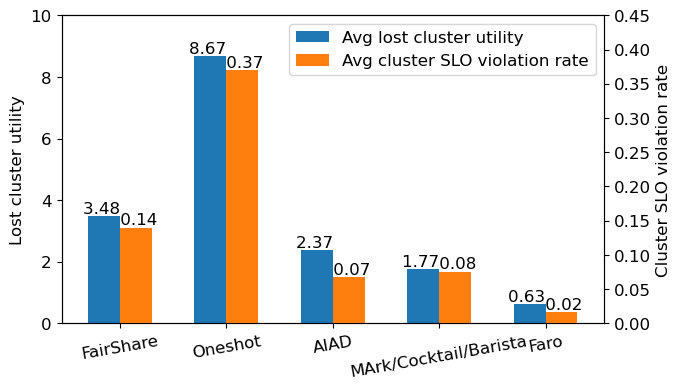

In [10]:
# figsize=(7.4, 4.8)
# figsize=(8.4, 4.8)
figsize=(7, 4)

merged_df = pd.concat([
    lost_real_cluster_util_df[targets].mean(axis=0),
    lost_real_cluster_slo_df[targets].mean(axis=0),
], axis=1).rename(columns={0: "Avg lost cluster utility", 1: "Avg cluster SLO violation rate"})
merged_std_df = pd.concat([
    lost_real_cluster_util_df[targets].std(axis=0),
    lost_real_cluster_slo_df[targets].std(axis=0),
], axis=1).rename(columns={0: "Avg lost cluster utility", 1: "Avg cluster SLO violation rate"})
# ax = merged_df.plot.bar(secondary_y="Avg cluster SLO violation rate", mark_right=False, figsize=figsize, width=0.6, yerr=merged_std_df, capsize=3)
ax = merged_df.plot.bar(secondary_y="Avg cluster SLO violation rate", mark_right=False, figsize=figsize, width=0.6)

ax.set_ylim(top=10)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_xlabel("")
ax.set_ylabel("Lost cluster utility")

new_labels = []
for text in ax.get_xticklabels():
    splits = text.get_text().split("-")
    text.set_text(splits[0])
    new_labels.append(text)
ax.set_xticklabels(new_labels, rotation=0)

right_ax = ax.right_ax
right_ax.set_ylim(top=0.45)
right_ax.set_ylabel("Cluster SLO violation rate")

for bar in ax.containers:
    if isinstance(bar, matplotlib.container.BarContainer):
        ax.bar_label(bar, fmt="%.2f ")

for bar in right_ax.containers:
    if isinstance(bar, matplotlib.container.BarContainer):
        right_ax.bar_label(bar, fmt=" %.2f")

ax.set_xticklabels(ax.get_xticklabels(), rotation=10)
ax.get_figure().savefig(f"images/32vms_{num_cpus}_avg_lost_cluster_utility_slo_real.eps", bbox_inches='tight')

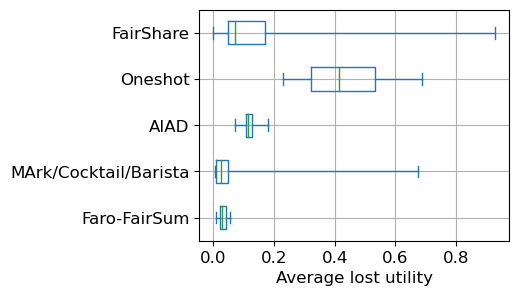

In [11]:
# boxplot_figsize = (6, 4)
boxplot_figsize = (4, 3)

ax = (1 - real_avg_util_df).plot.box(rot=0, vert=False, grid=True, whis=(0, 100), figsize=boxplot_figsize)
ax.invert_yaxis()
ax.set_xlabel("Average lost utility")
ax.get_figure().savefig(f"images/32vms_{num_cpus}_box_avg_lost_utility_real.eps", bbox_inches='tight')

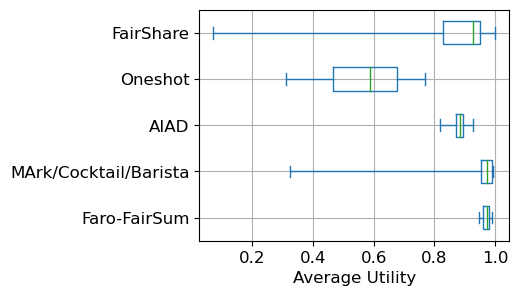

In [12]:
ax = real_avg_util_df.plot.box(rot=0, vert=False, grid=True, whis=(0, 100), figsize=boxplot_figsize)
ax.invert_yaxis()
ax.set_xlabel("Average Utility")
ax.get_figure().savefig(f"images/32vms_{num_cpus}_box_avg_utility_real.eps", bbox_inches='tight')

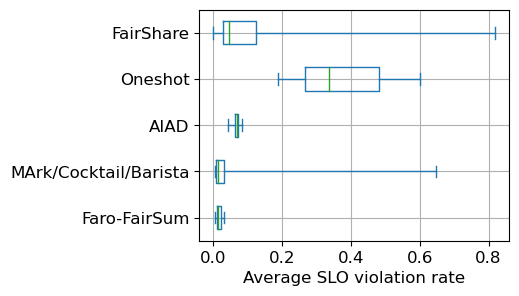

In [13]:
ax = real_slo_rates_df.plot.box(rot=0, vert=False, grid=True, whis=(0, 100), figsize=boxplot_figsize)
ax.invert_yaxis()
ax.set_xlabel("Average SLO violation rate")
ax.get_figure().savefig(f"images/32vms_{num_cpus}_box_slo_violation_real.eps", bbox_inches='tight')

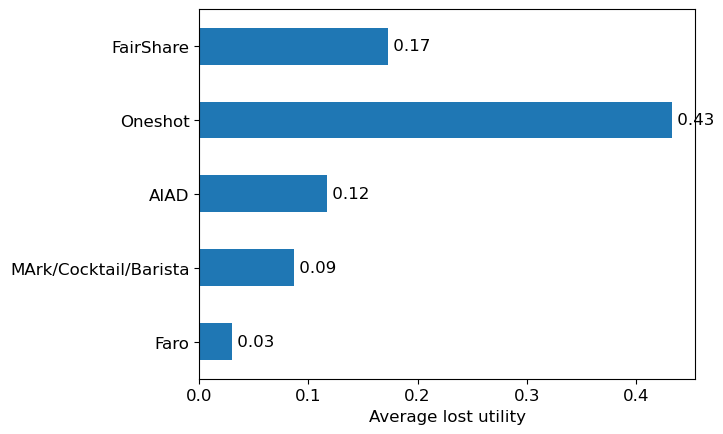

In [14]:
ax = (1 - real_avg_util_df.mean())[targets].plot.barh()
# ax = (1 - real_avg_util_df.mean()).plot.barh()
ax.set_xlabel("Average lost utility")

new_labels = []
for text in ax.get_yticklabels():
    splits = text.get_text().split("-")
    text.set_text(splits[0])
    new_labels.append(text)
ax.set_yticklabels(new_labels)

ax.invert_yaxis()
for bar in ax.containers:
    ax.bar_label(bar, fmt=" %.2f")
if num_cpus == 32:
    ax.set_xlim(None, 0.5)
# elif num_cpus == 36:
    # ax.set_xlim(None, 0.4)
elif num_cpus == 16:
    ax.set_xlim(None, 1.0)
ax.get_figure().savefig(f"images/32vms_{num_cpus}_avg_lost_utility_real.eps", bbox_inches='tight')


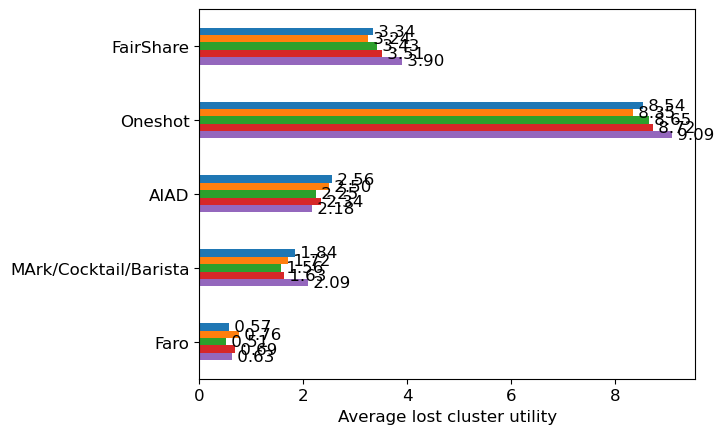

In [15]:
ax = lost_real_cluster_util_df[targets].transpose().plot.barh(legend=False)
# # ax = (1 - real_avg_util_df.mean()).plot.barh()
ax.set_xlabel("Average lost cluster utility")

new_labels = []
for text in ax.get_yticklabels():
    splits = text.get_text().split("-")
    text.set_text(splits[0])
    new_labels.append(text)
ax.set_yticklabels(new_labels)

ax.invert_yaxis()
for bar in ax.containers:
    ax.bar_label(bar, fmt=" %.2f")

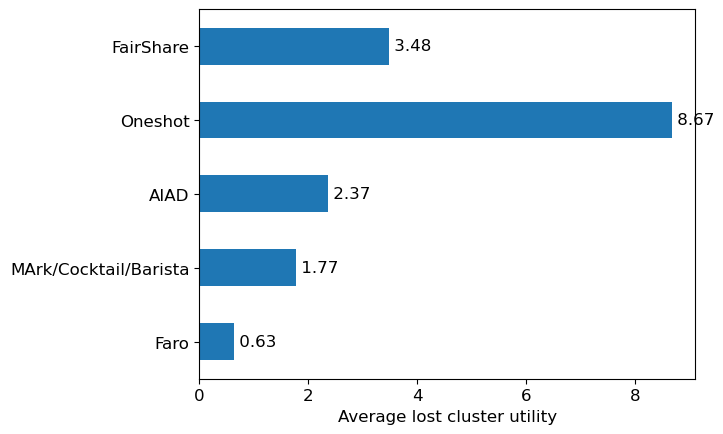

In [16]:
# ax = lost_real_cluster_util_df[targets].mean(axis=0).plot.barh(xerr=lost_real_cluster_util_df[targets].std(axis=0), legend=False, capsize=3)
ax = lost_real_cluster_util_df[targets].mean(axis=0).plot.barh(legend=False)
ax.set_xlabel("Average lost cluster utility")

new_labels = []
for text in ax.get_yticklabels():
    splits = text.get_text().split("-")
    text.set_text(splits[0])
    new_labels.append(text)
ax.set_yticklabels(new_labels)

ax.invert_yaxis()
for bar in ax.containers:
    if isinstance(bar, matplotlib.container.BarContainer):
        ax.bar_label(bar, fmt=" %.2f")
ax.get_figure().savefig(f"images/32vms_{num_cpus}_avg_lost_cluster_utility_real.eps", bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 640x480 with 0 Axes>

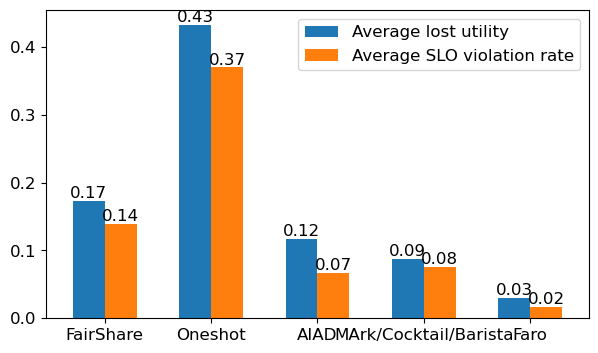

In [17]:
fig = plt.figure()
merged_df = merge((1-real_avg_util_df.mean()), (real_slo_rates_df).mean())
merged_df.rename(columns={"Cluster": "Average lost utility", "Simulation": "Average SLO violation rate"}, inplace=True)
ax = merged_df.loc[targets].plot.bar(figsize=figsize, width=0.6)
# plt.ylabel("Average lost utility / SLO violation rate")
plt.xticks(rotation=0)

new_labels = []
for text in ax.get_xticklabels():
    splits = text.get_text().split("-")
    text.set_text(splits[0])
    new_labels.append(text)
ax.set_xticklabels(new_labels)

# ax.invert_yaxis()
for bar in ax.containers:
    ax.bar_label(bar, fmt="%.2f")
if num_cpus in [32, 36]:
    ax.set_ylim(None, 0.55)
elif num_cpus == 16:
    ax.set_ylim(None, 1.0)
ax.get_figure().savefig(f"images/32vms_{num_cpus}_avg_lost_utility_slo_real.eps", bbox_inches='tight')

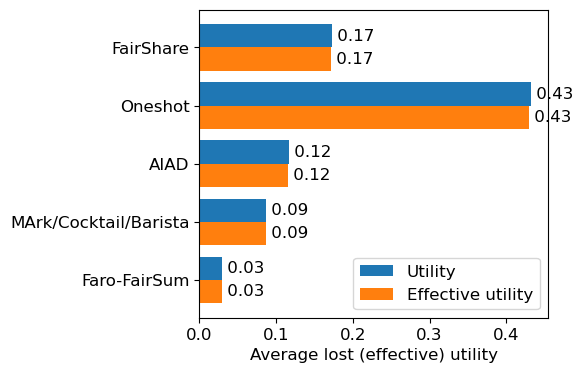

In [18]:
comparison_figsize=(4.5, 4)
comparison_width = 0.9

merged_df = merge((1-real_avg_util_df).mean(), (1-real_avg_effective_util_df).mean())
merged_df.rename(columns={"Cluster": "Utility", "Simulation": "Effective utility"}, inplace=True)
ax = merged_df.plot.barh(figsize=comparison_figsize, width=0.8)
ax.invert_yaxis()
for bar in ax.containers:
    ax.bar_label(bar, fmt=" %.2f")
# ax.set_title(f"Average utility (max replicas: {num_cpus})")
ax.set_xlabel("Average lost (effective) utility")

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc=4)

# ax.get_figure().savefig(f"images/{num_cpus}_comparison_avg_lost_util_and_effective_util.eps", bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


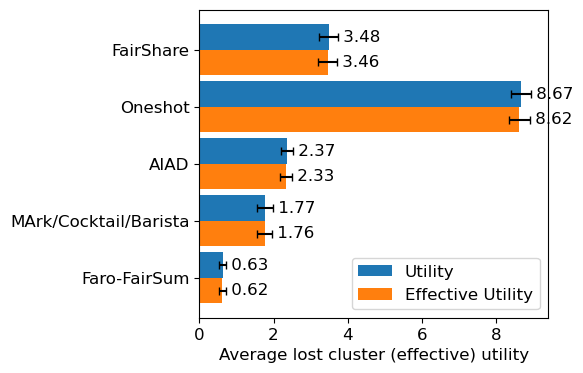

In [19]:
merged_df = merge(lost_real_cluster_util_df.mean(axis=0), lost_real_cluster_effective_util_df.mean(axis=0))
merged_df.rename(columns={"Cluster": "Utility", "Simulation": "Effective Utility"}, inplace=True)
merged_std_df = merge(lost_real_cluster_util_df.std(axis=0), lost_real_cluster_effective_util_df.std(axis=0))
merged_std_df.rename(columns={"Cluster": "Utility", "Simulation": "Effective Utility"}, inplace=True)
ax = merged_df.plot.barh(figsize=comparison_figsize, width=comparison_width, xerr=merged_std_df, capsize=3)
ax.invert_yaxis()
for bar in ax.containers:
    if isinstance(bar, matplotlib.container.BarContainer):
        ax.bar_label(bar, fmt=" %.2f")
# ax.set_title(f"Average utility (max replicas: {num_cpus})")
ax.set_xlabel("Average lost cluster (effective) utility")

ax.get_figure().savefig(f"images/32vms_{num_cpus}_comparison_cluster_lost_util_and_effective_util.eps", bbox_inches='tight')